<a href="https://colab.research.google.com/github/shivannadm/Data_Science_path/blob/main/01_Test_Evolution_Strategy_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Reference:** https://github.com/huseinzol05/Stock-Prediction-Models



In [30]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [30]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [ ]:
df = pd.read_csv('/content/sample_data/TATA.csv')
df.head()

In [ ]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
l = len(close) - 1

In [ ]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [ ]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, money, max_buy, max_sell):
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        # Check if buy[0] is NaN and replace with 0 if it is
        buy_amount = int(buy[0]) if not np.isnan(buy[0]) else 0
        return np.argmax(decision[0]), buy_amount

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [ ]:
model = Model(window_size, 500, 3)
agent = Agent(model, 10000, 5, 5)
agent.fit(iterations=500, checkpoint=50)

<ipython-input-22-2a0c0554930d>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buy_amount = int(buy[0]) if not np.isnan(buy[0]) else 0


iter 50. reward: 61.603500
iter 100. reward: 85.176000
iter 150. reward: 100.709000
iter 200. reward: 103.610000
iter 250. reward: 102.729500
iter 300. reward: 113.340000
iter 350. reward: 112.866500
iter 400. reward: 122.729000
iter 450. reward: 124.347500
iter 500. reward: 128.568000
time taken to train: 181.17350244522095 seconds


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<ipython-input-22-2a0c0554930d>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buy_amount = int(buy[0]) if not np.isnan(buy[0]) else 0


day 0: buy 5 units at price 3528.000000, total balance 6472.000000
day 1: buy 1 units at price 708.950000, total balance 5763.050000
day 2: buy 1 units at price 722.450000, total balance 5040.600000
day 3, sell 5 units at price 3609.750000, investment 2.317177 %, total balance 8650.350000,
day 4, sell 2 units at price 1441.600000, investment 103.342972 %, total balance 10091.950000,
day 6: buy 5 units at price 3601.500000, total balance 6490.450000
day 7: buy 1 units at price 732.400000, total balance 5758.050000
day 8: buy 5 units at price 3654.000000, total balance 2104.050000
day 9, sell 5 units at price 3644.750000, investment 404.498581 %, total balance 5748.800000,
day 11: buy 5 units at price 3544.250000, total balance 2204.550000
day 12: buy 1 units at price 724.700000, total balance 1479.850000
day 13: buy 5 units at price 3597.750000, total balance -2117.900000
day 17, sell 5 units at price 3953.000000, investment 9.759822 %, total balance 1835.100000,
day 18, sell 5 units at

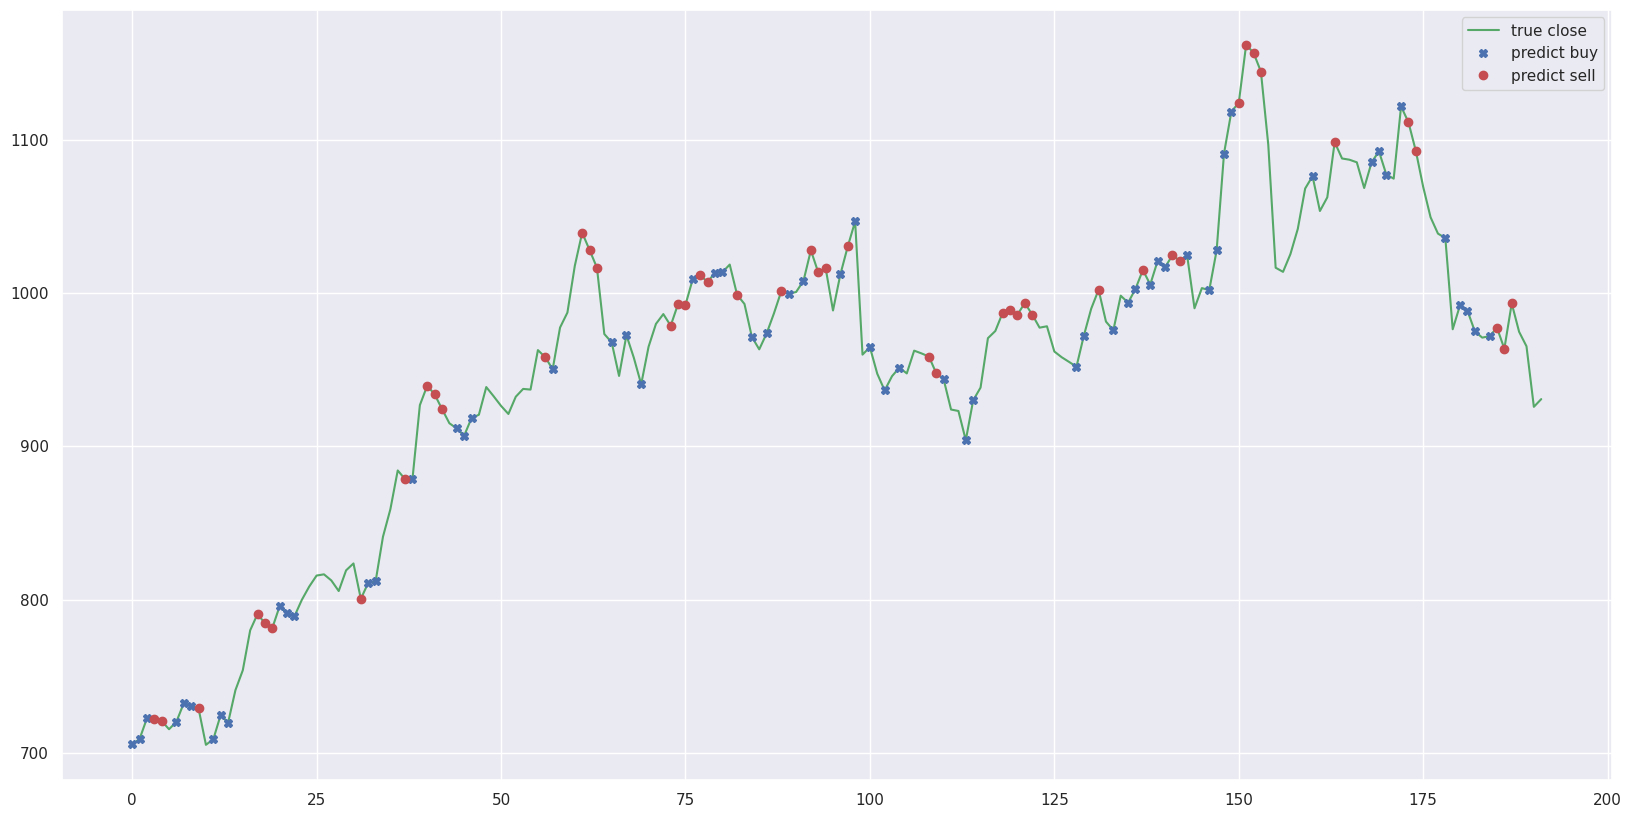

In [ ]:
agent.buy()